In [2]:
"""
[V7]
Blend 7 Models:
* kibuna-nn-hs-1024-last-train (aka. 2stage-NN, LB: 0.01822)
* simpleNN-oldcv (LB: 0.01836)
* deepinsight-efficientnet-v7-b3-infer (LB: 0.01850)
* deepinsight_resnest_lightning_v2_infer (LB: 0.01854)
* deepinsight_resnest_lightning_v1_infer (LB: 0.01853)
* fork-of-2heads-looper-super-puper-markpeng-infer (LB: 0.1836)
* improving-mark-s-2-heads-model-infer.py (LB: 0.1844)

Removed for now due to low weights:
* 503-203-tabnet-with-nonscored-features (LB: 0.01836)


"""

kernel_mode = False

import os
import numpy as np
import pandas as pd
import time
import random
import math
import datetime
import glob

pd.set_option('display.max_rows', None)

from numba import njit
from scipy.optimize import minimize, fsolve

import optuna

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import gc
gc.enable()

rand_seed = 1120

search_mode = True
run_submit_script = False

method = "CV"
# method = "scipy"
# method = "optuna"
study_name = "moa_blend_team_v7"
# n_trials = 500
# n_trials = 3000
n_trials = 5000

In [3]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/gen-efficientnet-pretrained/tf_efficientnet_*.pth /root/.cache/torch/hub/checkpoints/
# !cp ../input/deepinsight-resnest-v1-resnest50/*.pth /root/.cache/torch/hub/checkpoints/
# !cp ../input/deepinsight-resnest-v2-resnest50-output/*.pth /root/.cache/torch/hub/checkpoints/
# !ls -la /root/.cache/torch/hub/checkpoints/

In [4]:
# !cp ../input/kaggle-moa-team/scripts/* .
# !ls -la

In [5]:
# !pip install --no-index --find-links /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl pytorch-tabnet

In [6]:
dataset_folder = "../input/lish-moa" if kernel_mode else "/workspace/Kaggle/MoA/"

# Add your model inference script here
# Tuple Format: (script, oof_filename, output_filename, weight)
model_list = [
    # 10 folds
    ("2stageNN_with_ns_oldcv_10folds.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/2stageNN_with_ns_oldcv_10folds.py",
     "../../Github/kaggle_moa_team/oof/oof_2stageNN_ns_oldcv_10folds.npy",
     "submission_2stageNN_with_ns_oldcv_10folds.csv",
     0.36295047115403034),
    
    ("script_simpleNN_oldcv_10folds.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/script_simpleNN_oldcv_10folds.py",
     "../../Github/kaggle_moa_team/oof/oof_NN_oldcv_10fold.npy",
     "submission_script_simpleNN_oldcv_10folds.csv",
     0.00019665601658366993),
    
    #     ("2stageNN_with_ns_oldcv.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/2stageNN_with_ns_oldcv.py",
    #      "../../Github/kaggle_moa_team/oof/oof_2stageNN_ns_oldcv.npy",
    #      "submission_2stageNN_with_ns_oldcv_0.01822.csv",
    #      0.323528084383917),

    #     ("script_simpleNN_oldcv.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/script_simpleNN_oldcv.py",
    #      "../../Github/kaggle_moa_team/oof/oof_script_simpleNN_oldcv.npy",
    #      "submission_script_simpleNN_oldcv_0.01836.csv",
    #      0.08786476491118465),
    
    #     ("fork-of-2heads-looper-super-puper-markpeng-infer.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/fork-of-2heads-looper-super-puper-markpeng-infer.py",
    #      "../../Github/kaggle_moa_team/oof/oof_fork-of-2heads-looper-super-puper-markpeng.npy",
    #      "submission_2heads-looper-super-puper_0.01836.csv",
    #      0.018966959973949222),
    
    ("improving-mark-s-2-heads-model-infer.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/improving-mark-s-2-heads-model-infer.py",
     "../../Github/kaggle_moa_team/oof/oof_improving-mark-s-2-heads-model_0.015660083675738144.npy",
     "submission_improving-mark-s-2-heads-model.csv",
     0.10383226438101152),
    
    ("deepinsight_efficientnet_lightning_v7_b3_infer.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/deepinsight_efficientnet_lightning_v7_b3_infer.py",
     "../../Github/kaggle_moa_team/oof/oof_deepinsight_efficientnet_lightning_v7_b3_0.01850.npy",
     "submission_effnet_v7_b3_0.01850.csv",
     0.16907012564901389),
    
    ("deepinsight_resnest_lightning_v1_infer.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/deepinsight_resnest_lightning_v1_infer.py",
     "../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v1_resnest50_0.014619621213185928.npy",
     "submission_resnest_v1_0.01853.csv",
     0.10211240990528128),
    
    ("deepinsight_resnest_lightning_v2_infer.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/deepinsight_resnest_lightning_v2_infer.py",
     "../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v2_resnest50_0.01854.npy",
     "submission_resnest_v2_0.01854.csv",
     0.26308884808653726),
    
    #     ("script_tabnet_ns_oldcv.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/script_tabnet_ns_oldcv.py",
    #      "../../Github/kaggle_moa_team/oof/oof_tabnet_ns_oldcv.npy",
    #      "submission_tabnet_ns_oldcv_0.01836.csv",
    #      0.0013224625996093413),
]

model_path = "." if kernel_mode else dataset_folder

In [7]:
train_features = pd.read_csv(f"{dataset_folder}/train_features.csv",
                             engine='c')
train_labels = pd.read_csv(f'{dataset_folder}/train_targets_scored.csv',
                           engine='c')
train_classes = [c for c in train_labels.columns if c != "sig_id"]

non_control_group_rows = train_features["cp_type"] == "trt_cp"
non_control_group_train_labels = train_labels.loc[
    non_control_group_rows, :].copy().reset_index(drop=True)

submission = pd.read_csv(f'{dataset_folder}/sample_submission.csv')
submission.iloc[:, 1:] = 0

In [8]:
def mean_logloss(y_pred, y_true):
    logloss = (1 - y_true) * np.log(1 - y_pred +
                                    1e-15) + y_true * np.log(y_pred + 1e-15)
    return np.nanmean(-logloss)


def save_pickle(obj, folder, name):
    dump(obj, open(f"{folder}/{name}.pkl", 'wb'), pickle.HIGHEST_PROTOCOL)


def load_pickle(path):
    return load(open(path, 'rb'))

In [9]:
# Reference: https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0/notebook
# CPMP's logloss from https://www.kaggle.com/c/lish-moa/discussion/183010
def log_loss_numpy(y_pred, y_true):
    y_true_ravel = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = np.where(y_true_ravel == 1, -np.log(y_pred),
                    -np.log(1 - y_pred))
    return loss.mean()

def func_numpy_metric(weights):
    oof_blend = np.tensordot(weights, all_oof, axes=((0), (0)))
    return log_loss_numpy(oof_blend, y_true)

@njit
def grad_func_jit(weights):
    oof_clip = np.minimum(1 - 1e-15, np.maximum(all_oof, 1e-15))
    gradients = np.zeros(all_oof.shape[0])
    for i in range(all_oof.shape[0]):
        a, b, c = y_true, oof_clip[i], np.zeros(
            (all_oof.shape[1], all_oof.shape[2]))
        for j in range(oof.shape[0]):
            if j != i:
                c += weights[j] * oof_clip[j]
        gradients[i] = -np.mean(
            (-a * b + (b**2) * weights[i] + b * c) /
            ((b**2) *
             (weights[i]**2) + 2 * b * c * weights[i] - b * weights[i] +
             (c**2) - c))
    return gradients

## TPE (Tree-structured Parzen Estimator) and Sequential Least Squares Programming (SLSQP)
https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html

In [10]:
def run_inference_scripts(submission, weights=None, target_weights=None):
    for i, (script, oof_filename, output_filename, weight) in enumerate(model_list):
        print(f"Generating submission file from {script} ......")
        infer_start = time.time()
        !python {model_path}/{script}
        infer_elapsed = time.time() - infer_start
        print(f"Time spent on inference: {infer_elapsed/60:.2f} minutes.")

        model_submit = pd.read_csv(output_filename, engine='c')
        print(model_submit.head(5))
        print(model_submit.shape)

        if target_weights is not None:
            for j, target in enumerate(train_classes):
                print(f"Blending {script} for {target} with weight: {optimized_target_weights[j][i]} ......")
                submission.iloc[:, j+1] += model_submit.iloc[:, j+1] * optimized_target_weights[j][i]
        elif weights is None:
            print(f"Blending {script} with weight: {weight} ......")
            submission.iloc[:, 1:] += weight * model_submit.iloc[:, 1:]
        else:
            print(f"Blending {script} with weight: {weights[i]} ......")
            submission.iloc[:, 1:] += weights[i] * model_submit.iloc[:, 1:]

    return submission

In [11]:
total_start = time.time()

if not search_mode and run_submit_script:
    if method == "scipy_per_target":
        weights_path = glob.glob(f'{model_path}/{study_name}_*.pkl')[0]
        print(f"Loading target-wise optimized weights from {weights_path} ......")
        optimized_target_weights = load_pickle(weights_path)

        # For 206 target weights
        submission = run_inference_scripts(
            submission, target_weights=optimized_target_weights)
    else:
        submission = run_inference_scripts(submission)

elif search_mode and method == "CV":
    y_true = non_control_group_train_labels[train_classes].values

    all_oof = np.zeros(
        (len(model_list), non_control_group_train_labels.shape[0], 206))
    blend_oof = np.zeros((non_control_group_train_labels.shape[0], 206))
    print(all_oof.shape)
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        all_oof[i, :, :] = oof
        blend_oof += oof * weight

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")

    blend_oof_loss = mean_logloss(blend_oof, y_true)
    print(f"Blend OOF Validation Loss: {blend_oof_loss:.6f}\n")

elif search_mode and method == "optuna":
    print("[Optuna]")
    ## Search Best Blend Weights by Optuna ##
    model_oofs = []

    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        oof_loss = mean_logloss(
            oof, non_control_group_train_labels[train_classes].values)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")
        model_oofs.append(oof)

    def objective(trial):
        weights = []
        for i in range(len(model_list)):
            weights.append(trial.suggest_float(f"w{i}", 0, 1.0))

        blend = np.zeros(model_oofs[0].shape)
        for i in range(len(model_list)):
            blend += weights[i] * model_oofs[i]
        blend = np.clip(blend, 0, 1.0)

        loss = mean_logloss(
            blend, non_control_group_train_labels[train_classes].values)
        return loss

    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=0,
        interval_steps=1,
    )
    sampler = optuna.samplers.TPESampler(seed=rand_seed)
    study = optuna.create_study(direction="minimize",
                                pruner=pruner,
                                sampler=sampler,
                                study_name=study_name,
                                storage=f'sqlite:///{study_name}.db',
                                load_if_exists=True)

    study.optimize(objective,
                   n_trials=n_trials,
                   timeout=None,
                   gc_after_trial=True,
                   n_jobs=-1)

    trial = study.best_trial

    if run_submit_script:
        optimal_weights = []
        for i, (script, oof_filename, output_filename,
                _) in enumerate(model_list):
            optimal_weights.append(trial.params[f"w{i}"])
        submission = run_inference_scripts(submission, weights=optimal_weights)

    print("\n[Optuna]")
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

elif search_mode and method == "scipy":
    print("[Scipy SLSQP]")
    # Optimise Blending Weights with Bonus
    # https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0/notebook
    model_oofs = []
    y_true = non_control_group_train_labels[train_classes].values

    all_oof = np.zeros(
        (len(model_list), non_control_group_train_labels.shape[0], 206))
    print(all_oof.shape)
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        all_oof[i, :, :] = oof

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")
        model_oofs.append(oof)

    tol = 1e-10
    init_guess = [1 / all_oof.shape[0]] * all_oof.shape[0]
    bnds = [(0, 1) for _ in range(all_oof.shape[0])]
    cons = {
        'type': 'eq',
        'fun': lambda x: np.sum(x) - 1,
        'jac': lambda x: [1] * len(x)
    }

    print('Inital Blend OOF:', func_numpy_metric(init_guess))

    start_time = time.time()
    res_scipy = minimize(
        fun=func_numpy_metric,
        x0=init_guess,
        method='SLSQP',
        # jac=grad_func_jit,  # grad_func
        bounds=bnds,
        constraints=cons,
        tol=tol)
    print("\n[Scipy SLSQP]")
    print(
        f'[{str(datetime.timedelta(seconds = time.time() - start_time))[2:7]}] Optimised Blend OOF:',
        res_scipy.fun)
    print(f'Optimised Weights: {res_scipy.x}\n')

    if run_submit_script:
        submission = run_inference_scripts(submission, weights=res_scipy.x)

# Target-wise Weight Optimization #

elif search_mode and method == "scipy_per_target":
    print("[Scipy SLSQP]")
    # Optimise Blending Weights with Bonus
    # https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0/notebook
    model_oofs = []
    y_true = non_control_group_train_labels[train_classes].values

    all_oof = np.zeros(
        (len(model_list), non_control_group_train_labels.shape[0], 206))
    print(all_oof.shape)
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        all_oof[i, :, :] = oof

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")
        model_oofs.append(oof)

    print("\n[Scipy SLSQP Per Target]")
    optimized_target_weights = []
    for i, target in enumerate(train_classes):
        tol = 1e-10
        init_guess = [1 / all_oof.shape[0]] * all_oof.shape[0]
        bnds = [(0, 1) for _ in range(all_oof.shape[0])]
        cons = {
            'type': 'eq',
            'fun': lambda x: np.sum(x) - 1,
            'jac': lambda x: [1] * len(x)
        }

        def func_numpy_metric_targes(weights):
            oof_blend = np.tensordot(weights,
                                     all_oof[:, :, i],
                                     axes=((0), (0)))
            return log_loss_numpy(oof_blend, y_true[:, i])

        start_time = time.time()
        res_scipy = minimize(
            fun=func_numpy_metric_targes,
            x0=init_guess,
            method='SLSQP',
            # jac=grad_func_jit,  # grad_func
            bounds=bnds,
            constraints=cons,
            tol=tol)

        print(
            f'[{str(datetime.timedelta(seconds = time.time() - start_time))[2:7]}] ' + \
            f'Optimised Blend OOF for {target}:', res_scipy.fun)
        print(f'Optimised Weights for {target}: {res_scipy.x}\n')
        optimized_target_weights.append(res_scipy.x)

    blend_targets_oof = np.zeros(
        (non_control_group_train_labels.shape[0], 206))
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        for j in range(206):
            blend_targets_oof[:,
                              j] += oof[:, j] * optimized_target_weights[j][i]

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")

    blend_targets_oof_loss = mean_logloss(blend_targets_oof, y_true)
    print(
        f"Blend Target-Wise OOF Validation Loss: {blend_targets_oof_loss:.6f}\n"
    )

    # Save optimized weights per target
    save_pickle(optimized_target_weights, model_path,
                f"{study_name}_{blend_targets_oof_loss}")

    if run_submit_script:
        # For 206 target weights
        submission = run_inference_scripts(
            submission, target_weights=optimized_target_weights)

(6, 21948, 206)
Loading OOF from ../../Github/kaggle_moa_team/oof/oof_2stageNN_ns_oldcv_10folds.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/2stageNN_with_ns_oldcv_10folds.py: 0.015461

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_NN_oldcv_10fold.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/script_simpleNN_oldcv_10folds.py: 0.015741

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_improving-mark-s-2-heads-model_0.015660083675738144.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/improving-mark-s-2-heads-model-infer.py: 0.015660

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_deepinsight_efficientnet_lightning_v7_b3_0.01850.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/deepinsight_efficientnet_lightning_v7_b3_infer.py: 0.016016

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v1_resnest50_0.014619621213185928.npy ......
OOF Validation Loss o

In [12]:
total_elapsed = time.time() - total_start
print(f"Total time spent: {total_elapsed/60:.2f} minutes.")

Total time spent: 0.04 minutes.


In [13]:
# # [V7 - without TabNet, Mark's 2heads, 10-folds 2StageNN and SimpleNN]
# [Optuna]
# Loading OOF from ../../Github/kaggle_moa_team/oof/oof_2stageNN_ns_oldcv_10folds.npy ......
# OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/2stageNN_with_ns_oldcv_10folds.py: 0.015461

# Loading OOF from ../../Github/kaggle_moa_team/oof/oof_NN_oldcv_10fold.npy ......
# OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/script_simpleNN_oldcv.py: 0.015741

# Loading OOF from ../../Github/kaggle_moa_team/oof/oof_improving-mark-s-2-heads-model_0.015660083675738144.npy ......
# OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/improving-mark-s-2-heads-model-infer.py: 0.015660

# Loading OOF from ../../Github/kaggle_moa_team/oof/oof_deepinsight_efficientnet_lightning_v7_b3_0.01850.npy ......
# OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/deepinsight_efficientnet_lightning_v7_b3_infer.py: 0.016016

# Loading OOF from ../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v1_resnest50_0.014619621213185928.npy ......
# OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/deepinsight_resnest_lightning_v1_infer.py: 0.015819

# Loading OOF from ../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v2_resnest50_0.01854.npy ......

# OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/deepinsight_resnest_lightning_v2_infer.py: 0.015756

# [Optuna]
# Number of finished trials: 10000
# Best trial:
#   Value: 0.015107277135046551
#   Params: 
#     w0: 0.36295047115403034
#     w1: 0.00019665601658366993
#     w2: 0.10383226438101152
#     w3: 0.16907012564901389
#     w4: 0.10211240990528128
#     w5: 0.26308884808653726

# [Scipy SLSQP]
# [00:48] Optimised Blend OOF: 0.015107004381942337
# Optimised Weights: [0.36727479 0.         0.08130163 0.17091322 0.10863643 0.27187394]

In [14]:
# [V6]
# [Optuna]
# Number of finished trials: 5000
# Best trial:
#   Value: 0.015173437622007157
#   Params: 
#     w0: 0.30923325055652684
#     w1: 0.09831493504786226
#     w2: 0.018966959973949222
#     w3: 0.19863369862866234
#     w4: 0.0013224625996093413
#     w5: 0.3728865483320761

# [Scipy SLSQP]
# [00:36] Optimised Blend OOF: 0.015172005464591968
# Optimised Weights: [3.20472642e-01 9.01191588e-02 1.78893358e-18 2.20448482e-01
#  3.27971157e-18 3.68959717e-01]

In [15]:
# [V5]
# Number of finished trials: 3000
# Best trial:
#   Value: 0.015344701181290615
#   Params: 
#     w0: 0.5141433844379889
#     w1: 0.11747776562133813
#     w2: 0.3668324643717302

# [00:14] Optimised Blend OOF: 0.015344695215068541
# Optimised Weights: [0.51922623 0.11292509 0.36784869]

In [16]:
# [V4]
# [Optuna]
# Number of finished trials: 3000
# Best trial:
#   Value: 0.015331901615194453
#   Params: 
#     w0: 0.4505928450756189
#     w1: 0.13010257032841785
#     w2: 0.06308933354044946
#     w3: 0.35639153615958885
#
# [Scipy]
# [00:23] Optimised Blend OOF: 0.015331777381591449
# Optimised Weights: [0.44090106 0.14508641 0.05945655 0.35455598]

In [17]:
# [V3]
# improving-mark-s-2-heads-model-infer
# Number of finished trials: 3000
# Best trial:
#   Value: 0.01515466145873492
#   Params: 
#     w0: 0.0002980690037490555
#     w1: 0.29771381784976886
#     w2: 0.1569191862042946
#     w3: 0.18156875605872544
#     w4: 0.36371774630338105

In [18]:
# [V3]
# fork-of-2heads-looper-super-puper-markpeng-infer
# Number of finished trials: 3000
# Best trial:
#   Value: 0.015170138066049686
#   Params: 
#     w0: 0.00019903389488299251
#     w1: 0.3853752127955825
#     w2: 0.015968332256452233
#     w3: 0.22945916769823432
#     w4: 0.3711290150522236

In [19]:
all_oof.shape, blend_oof.shape

((6, 21948, 206), (21948, 206))

## Correlation Analysis

In [57]:
class_counts = train_labels[train_classes].sum().to_frame(
    name="count").reset_index().rename(columns={"index": "class"})
class_counts = class_counts.sort_values(by="count",
                                        ascending=False).reset_index(drop=True)
class_counts

,class,count
0,nfkb_inhibitor,832
1,proteasome_inhibitor,726
2,cyclooxygenase_inhibitor,435
3,dopamine_receptor_antagonist,424
4,serotonin_receptor_antagonist,404
5,dna_inhibitor,402
6,glutamate_receptor_antagonist,367
7,adrenergic_receptor_antagonist,360
8,cdk_inhibitor,340
9,egfr_inhibitor,336


array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

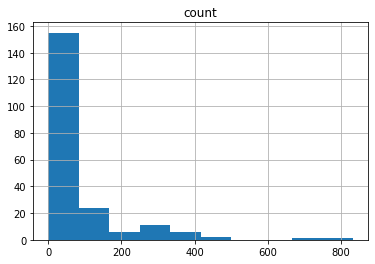

In [58]:
class_counts.hist()

In [59]:
# OOF scores per target
target_oof_losses = []
for i, target in enumerate(train_classes):
    print(target)
    # print(y_true[:, i])

    oof_loss = mean_logloss(blend_oof[:, i], y_true[:, i])
    target_oof_losses.append(oof_loss)
    print(f"Blend OOF Validation Loss of {target}: {oof_loss:.6f}\n")

5-alpha_reductase_inhibitor
Blend OOF Validation Loss of 5-alpha_reductase_inhibitor: 0.005490

11-beta-hsd1_inhibitor
Blend OOF Validation Loss of 11-beta-hsd1_inhibitor: 0.006240

acat_inhibitor
Blend OOF Validation Loss of acat_inhibitor: 0.008051

acetylcholine_receptor_agonist
Blend OOF Validation Loss of acetylcholine_receptor_agonist: 0.046114

acetylcholine_receptor_antagonist
Blend OOF Validation Loss of acetylcholine_receptor_antagonist: 0.067554

acetylcholinesterase_inhibitor
Blend OOF Validation Loss of acetylcholinesterase_inhibitor: 0.021372

adenosine_receptor_agonist
Blend OOF Validation Loss of adenosine_receptor_agonist: 0.015622

adenosine_receptor_antagonist
Blend OOF Validation Loss of adenosine_receptor_antagonist: 0.025165

adenylyl_cyclase_activator
Blend OOF Validation Loss of adenylyl_cyclase_activator: 0.001483

adrenergic_receptor_agonist
Blend OOF Validation Loss of adrenergic_receptor_agonist: 0.052940

adrenergic_receptor_antagonist
Blend OOF Validation 

Blend OOF Validation Loss of sigma_receptor_agonist: 0.011796

sigma_receptor_antagonist
Blend OOF Validation Loss of sigma_receptor_antagonist: 0.011609

smoothened_receptor_antagonist
Blend OOF Validation Loss of smoothened_receptor_antagonist: 0.008030

sodium_channel_inhibitor
Blend OOF Validation Loss of sodium_channel_inhibitor: 0.062479

sphingosine_receptor_agonist
Blend OOF Validation Loss of sphingosine_receptor_agonist: 0.008282

src_inhibitor
Blend OOF Validation Loss of src_inhibitor: 0.012183

steroid
Blend OOF Validation Loss of steroid: 0.002598

syk_inhibitor
Blend OOF Validation Loss of syk_inhibitor: 0.005011

tachykinin_antagonist
Blend OOF Validation Loss of tachykinin_antagonist: 0.017742

tgf-beta_receptor_inhibitor
Blend OOF Validation Loss of tgf-beta_receptor_inhibitor: 0.002283

thrombin_inhibitor
Blend OOF Validation Loss of thrombin_inhibitor: 0.006404

thymidylate_synthase_inhibitor
Blend OOF Validation Loss of thymidylate_synthase_inhibitor: 0.009864

tlr

In [60]:
target_loss_df = pd.DataFrame(data={
    "target": train_classes,
    "oof_logloss": target_oof_losses
},
                              columns=["target", "oof_logloss"
                                       ]).sort_values(by="oof_logloss",
                                                      ascending=False).reset_index(drop=True)
target_loss_df

,target,oof_logloss
0,cyclooxygenase_inhibitor,0.088414
1,dopamine_receptor_antagonist,0.084021
2,serotonin_receptor_antagonist,0.082769
3,glutamate_receptor_antagonist,0.080690
4,adrenergic_receptor_antagonist,0.078395
5,dna_inhibitor,0.076955
6,acetylcholine_receptor_antagonist,0.067554
7,sodium_channel_inhibitor,0.062479
8,calcium_channel_blocker,0.061947
9,phosphodiesterase_inhibitor,0.059268


In [61]:
all_oof.shape

(6, 21948, 206)

In [62]:
all_mean_oof = np.zeros((all_oof.shape[0], all_oof.shape[2]))
for i in range(len(model_list)):
    model_oof = all_oof[i, :, :]
    all_mean_oof[i, :] = np.mean(model_oof, axis=0)

In [63]:
model_names = [m[2] for m in model_list]
corr_df = pd.DataFrame(data=all_mean_oof.T, columns=model_names)
corr_df

,submission_2stageNN_with_ns_oldcv_10folds.csv,submission_script_simpleNN_oldcv_10folds.csv,submission_improving-mark-s-2-heads-model.csv,submission_effnet_v7_b3_0.01850.csv,submission_resnest_v1_0.01853.csv,submission_resnest_v2_0.01854.csv
0,0.001428,0.001467,0.001083,0.001278,0.001325,0.001201
1,0.001473,0.001506,0.001156,0.001332,0.001344,0.001251
2,0.001711,0.001764,0.001268,0.001463,0.001502,0.001459
3,0.009407,0.010021,0.009577,0.010243,0.009028,0.008302
4,0.014662,0.015434,0.015932,0.015122,0.014802,0.013872
5,0.004053,0.004163,0.003963,0.003873,0.003743,0.003692
6,0.003127,0.003259,0.002614,0.003081,0.002899,0.002826
7,0.004852,0.005125,0.004810,0.004903,0.005198,0.004756
8,0.001252,0.001192,0.000866,0.001158,0.001115,0.001006
9,0.013064,0.011625,0.012520,0.014261,0.012469,0.011098


In [64]:
print(np.min(corr_df.corr(method='pearson')))
corr_df.corr(method='pearson')

submission_2stageNN_with_ns_oldcv_10folds.csv    0.997225
submission_script_simpleNN_oldcv_10folds.csv     0.996029
submission_improving-mark-s-2-heads-model.csv    0.997148
submission_effnet_v7_b3_0.01850.csv              0.996058
submission_resnest_v1_0.01853.csv                0.996029
submission_resnest_v2_0.01854.csv                0.996284
dtype: float64


,submission_2stageNN_with_ns_oldcv_10folds.csv,submission_script_simpleNN_oldcv_10folds.csv,submission_improving-mark-s-2-heads-model.csv,submission_effnet_v7_b3_0.01850.csv,submission_resnest_v1_0.01853.csv,submission_resnest_v2_0.01854.csv
submission_2stageNN_with_ns_oldcv_10folds.csv,1.000000,0.997225,0.998049,0.997917,0.998072,0.998960
submission_script_simpleNN_oldcv_10folds.csv,0.997225,1.000000,0.998549,0.996058,0.996029,0.997265
submission_improving-mark-s-2-heads-model.csv,0.998049,0.998549,1.000000,0.997742,0.997148,0.997400
submission_effnet_v7_b3_0.01850.csv,0.997917,0.996058,0.997742,1.000000,0.997775,0.996284
submission_resnest_v1_0.01853.csv,0.998072,0.996029,0.997148,0.997775,1.000000,0.997448
submission_resnest_v2_0.01854.csv,0.998960,0.997265,0.997400,0.996284,0.997448,1.000000


Text(0.5, 1.0, 'Pearson Correlation Heatmap of Blend OOF Predictions')

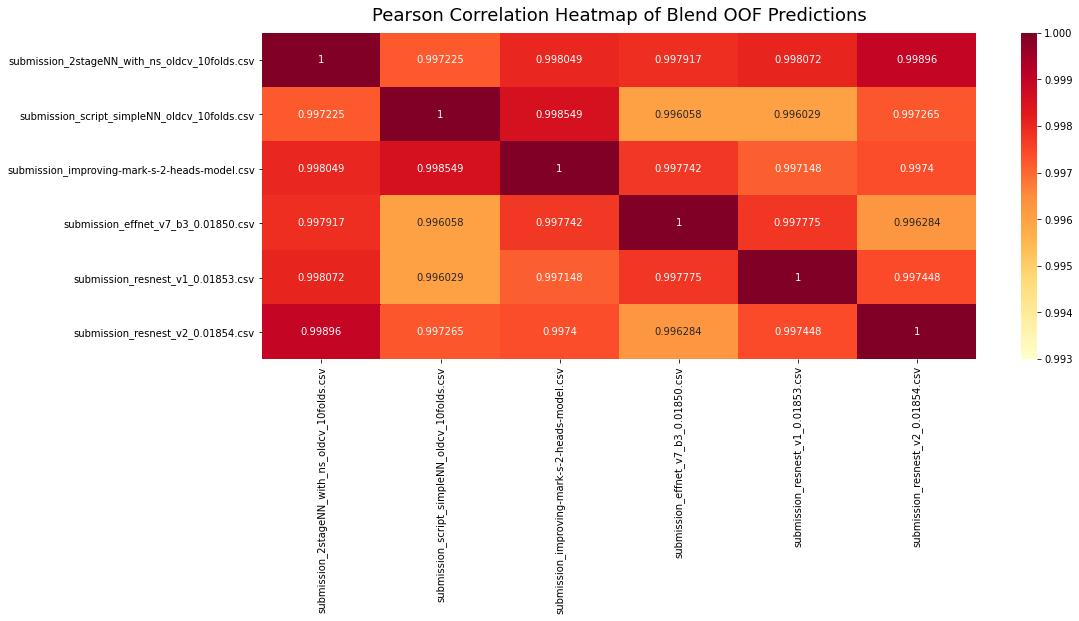

In [65]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df.corr(method='pearson'),
                      vmin=0.993,
                      vmax=1,
                      fmt='.6g',
                      cmap='YlOrRd',
                      annot=True)
                      # center=0.7)
                      # annot=True)
                      # cmap='jet')
                      # cmap='BrBG')
heatmap.set_title('Pearson Correlation Heatmap of Blend OOF Predictions',
                  fontdict={'fontsize': 18},
                  pad=12)

In [66]:
print(np.min(corr_df.corr(method='spearman')))
corr_df.corr(method='spearman')

submission_2stageNN_with_ns_oldcv_10folds.csv    0.993724
submission_script_simpleNN_oldcv_10folds.csv     0.992440
submission_improving-mark-s-2-heads-model.csv    0.993162
submission_effnet_v7_b3_0.01850.csv              0.992440
submission_resnest_v1_0.01853.csv                0.993711
submission_resnest_v2_0.01854.csv                0.994926
dtype: float64


,submission_2stageNN_with_ns_oldcv_10folds.csv,submission_script_simpleNN_oldcv_10folds.csv,submission_improving-mark-s-2-heads-model.csv,submission_effnet_v7_b3_0.01850.csv,submission_resnest_v1_0.01853.csv,submission_resnest_v2_0.01854.csv
submission_2stageNN_with_ns_oldcv_10folds.csv,1.000000,0.995059,0.996106,0.993724,0.994924,0.995744
submission_script_simpleNN_oldcv_10folds.csv,0.995059,1.000000,0.993683,0.992440,0.993711,0.995451
submission_improving-mark-s-2-heads-model.csv,0.996106,0.993683,1.000000,0.993162,0.994759,0.995246
submission_effnet_v7_b3_0.01850.csv,0.993724,0.992440,0.993162,1.000000,0.994193,0.994926
submission_resnest_v1_0.01853.csv,0.994924,0.993711,0.994759,0.994193,1.000000,0.996718
submission_resnest_v2_0.01854.csv,0.995744,0.995451,0.995246,0.994926,0.996718,1.000000


Text(0.5, 1.0, 'Spearman Correlation Heatmap of Blend OOF Predictions')

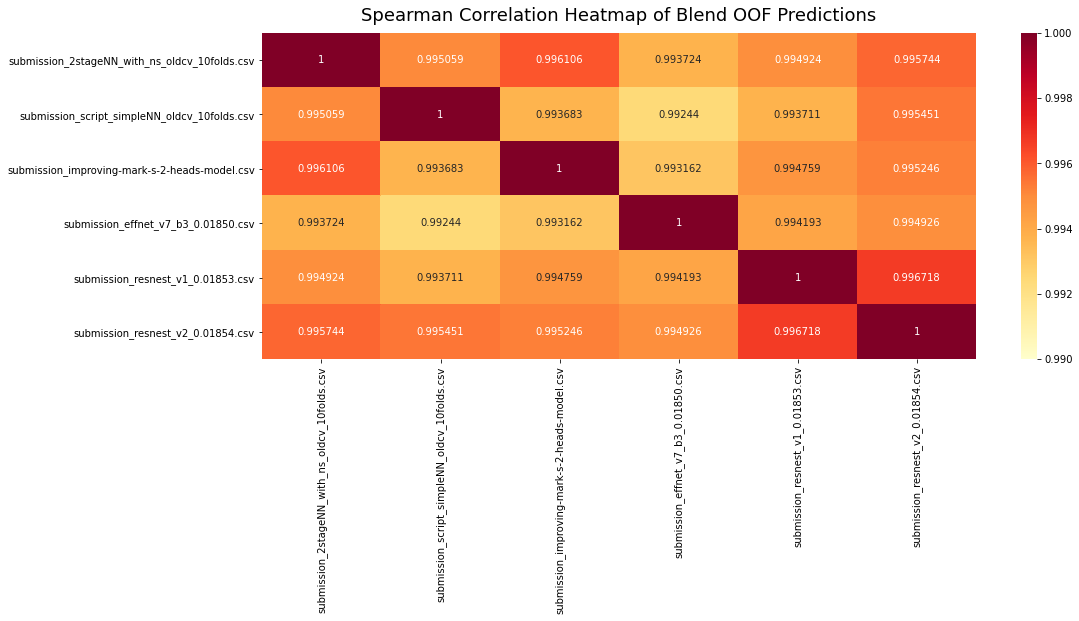

In [67]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df.corr(method='spearman'),
                      vmin=0.99,
                      vmax=1,
                      fmt='.6g',
                      cmap='YlOrRd',
                      annot=True)
                      # center=0.7)
                      # annot=True)
                      # cmap='jet')
                      # cmap='BrBG')
heatmap.set_title('Spearman Correlation Heatmap of Blend OOF Predictions',
                  fontdict={'fontsize': 18},
                  pad=12)

In [68]:
print(np.min(corr_df.corr(method='kendall')))
corr_df.corr(method='kendall')

submission_2stageNN_with_ns_oldcv_10folds.csv    0.937106
submission_script_simpleNN_oldcv_10folds.csv     0.927540
submission_improving-mark-s-2-heads-model.csv    0.935117
submission_effnet_v7_b3_0.01850.csv              0.927540
submission_resnest_v1_0.01853.csv                0.935591
submission_resnest_v2_0.01854.csv                0.941937
dtype: float64


,submission_2stageNN_with_ns_oldcv_10folds.csv,submission_script_simpleNN_oldcv_10folds.csv,submission_improving-mark-s-2-heads-model.csv,submission_effnet_v7_b3_0.01850.csv,submission_resnest_v1_0.01853.csv,submission_resnest_v2_0.01854.csv
submission_2stageNN_with_ns_oldcv_10folds.csv,1.000000,0.943074,0.949893,0.937106,0.942316,0.947810
submission_script_simpleNN_oldcv_10folds.csv,0.943074,1.000000,0.936349,0.927540,0.935591,0.944116
submission_improving-mark-s-2-heads-model.csv,0.949893,0.936349,1.000000,0.935117,0.942032,0.946199
submission_effnet_v7_b3_0.01850.csv,0.937106,0.927540,0.935117,1.000000,0.939664,0.941937
submission_resnest_v1_0.01853.csv,0.942316,0.935591,0.942032,0.939664,1.000000,0.954914
submission_resnest_v2_0.01854.csv,0.947810,0.944116,0.946199,0.941937,0.954914,1.000000


Text(0.5, 1.0, 'Kendall Correlation Heatmap of Blend OOF Predictions')

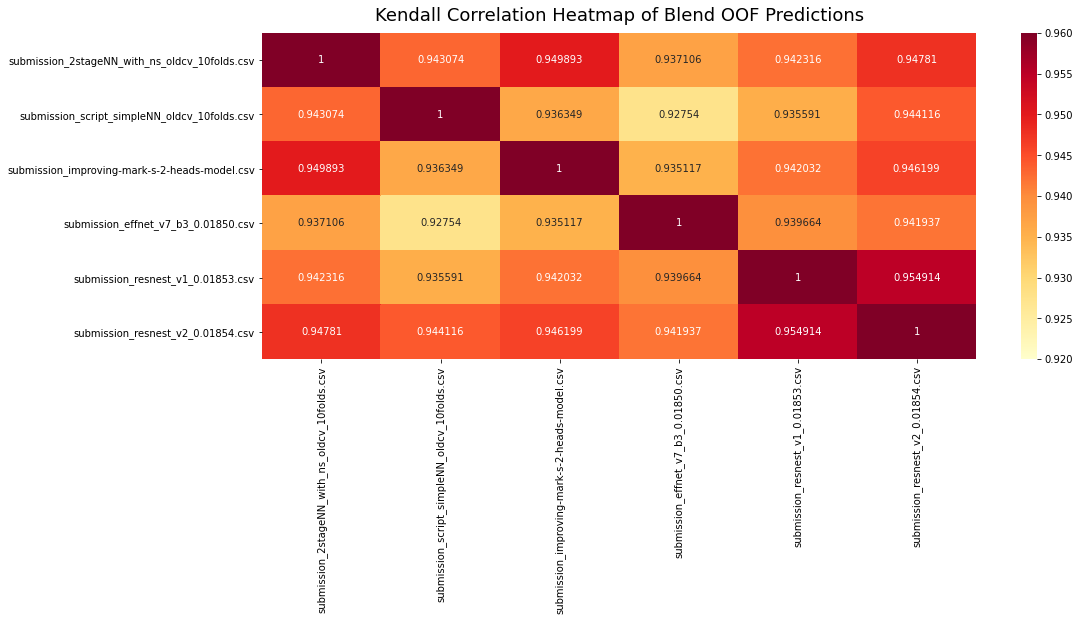

In [69]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df.corr(method='kendall'),
                      vmin=0.92,
                      vmax=0.96,
                      fmt='.6g',
                      cmap='YlOrRd',
                      annot=True)
# center=0.7)
# annot=True)
# cmap='jet')
# cmap='BrBG')
heatmap.set_title('Kendall Correlation Heatmap of Blend OOF Predictions',
                  fontdict={'fontsize': 18},
                  pad=12)

## Mean Correlation for Targets

In [ ]:
def get_corr(predictions):
    mat = np.zeros((len(predictions), len(predictions)))
    for i in range(len(predictions)):
        for j in range(len(predictions)):
            print(
                f'Mean Correlation (column-wise) [Model {i}-{j}]: {predictions[i][target_columns].corrwith(predictions[j][target_columns]).mean()}'
            )
            mat[i, j] = predictions[i][target_columns].corrwith(
                predictions[j][target_columns]).mean()
    return mat


predictions = [sub1, sub2, sub3, sub4, sub5, sub6, sub7]
mat = get_corr(predictions)
mat_df = pd.DataFrame(
    mat, columns=[f'Model-{i}' for i in range(1,
                                              len(predictions) + 1)])
mat_df.columns = [
    '2stageNN', '2heads Pytorch', 'simpleNNnewcv', 'efficientnet v7',
    'resnest v2', '2stage Tabnet', 'simpleNNoldcv'
]
mat_df.index = [
    '2stageNN', '2heads Pytorch', 'simpleNNnewcv', 'efficientnet v7',
    'resnest v2', '2stage Tabnet', 'simpleNNoldcv'
]
plt.figure(figsize=(14, 14))
sns.heatmap(mat_df, annot=True)

In [20]:
# model_names = [m[2] for m in model_list]
# mean_oof_corr = np.zeros((all_oof.shape[0], all_oof.shape[0]))
# for i in range(206):
#     target_oof = np.zeros((all_oof.shape[0], all_oof.shape[1]))
#     for j in range(len(model_list)):
#         target_oof[j, :] = all_oof[j, :, i]

#     corr_df = pd.DataFrame(data=target_oof.T, columns=model_names)
#     # target_corr = corr_df.corr(method='pearson')
#     target_corr = corr_df.corr(method='spearman')
#     # target_corr = corr_df.corr(method='kendall')
#     mean_oof_corr += target_corr / 206

In [ ]:
model_names = [m[2] for m in model_list]
mean_oof_corr = np.zeros((all_oof.shape[0], all_oof.shape[0]))
for i in range(len(model_list)):
    i_df = pd.DataFrame(all_oof[i])
    for j in range(len(model_list)):
        j_df = pd.DataFrame(all_oof[j])
        print(
            f'Mean Correlation (column-wise) [Model {i}-{j}]: {i_df.corrwith(j_df).mean()}'
        )
        mean_oof_corr[i, j] = i_df.corrwith(j_df).mean()

corr_df = pd.DataFrame(
    mean_oof_corr, columns=[f'Model-{i}' for i in range(1,
                                              len(model_list) + 1)])
corr_df.columns = model_names
corr_df.index = model_names

Mean Correlation (column-wise) [Model 0-0]: 1.0
Mean Correlation (column-wise) [Model 0-1]: 0.7536342293974783
Mean Correlation (column-wise) [Model 0-2]: 0.699082315030853
Mean Correlation (column-wise) [Model 0-3]: 0.5474950501213676
Mean Correlation (column-wise) [Model 0-4]: 0.5325637155622015
Mean Correlation (column-wise) [Model 0-5]: 0.5180809578606667
Mean Correlation (column-wise) [Model 1-0]: 0.7536342293974785


In [21]:
mean_oof_corr

,submission_2stageNN_with_ns_oldcv_10folds.csv,submission_script_simpleNN_oldcv_10folds.csv,submission_improving-mark-s-2-heads-model.csv,submission_effnet_v7_b3_0.01850.csv,submission_resnest_v1_0.01853.csv,submission_resnest_v2_0.01854.csv
submission_2stageNN_with_ns_oldcv_10folds.csv,1.000000,0.736214,0.674832,0.537824,0.533874,0.519696
submission_script_simpleNN_oldcv_10folds.csv,0.736214,1.000000,0.682495,0.528233,0.520520,0.502260
submission_improving-mark-s-2-heads-model.csv,0.674832,0.682495,1.000000,0.539621,0.531182,0.508211
submission_effnet_v7_b3_0.01850.csv,0.537824,0.528233,0.539621,1.000000,0.545338,0.535671
submission_resnest_v1_0.01853.csv,0.533874,0.520520,0.531182,0.545338,1.000000,0.720201
submission_resnest_v2_0.01854.csv,0.519696,0.502260,0.508211,0.535671,0.720201,1.000000


In [93]:
print(np.min(mean_oof_corr))

submission_2stageNN_with_ns_oldcv_10folds.csv    0.519696
submission_improving-mark-s-2-heads-model.csv    0.502260
submission_effnet_v7_b3_0.01850.csv              0.508211
submission_resnest_v1_0.01853.csv                0.528233
submission_resnest_v2_0.01854.csv                0.520520
submission_script_simpleNN_oldcv_10folds.csv     0.502260
dtype: float64


Text(0.5, 1.0, 'Mean Pearson Correlation Heatmap of Blend OOF Predictions for Targets')

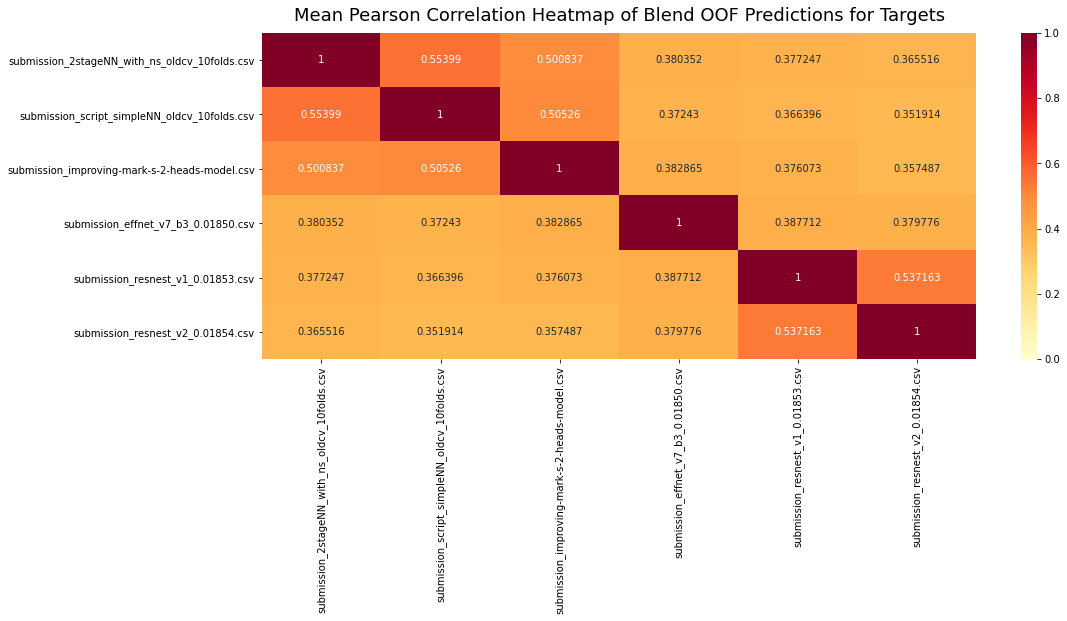

In [89]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(mean_oof_corr,
                      vmin=0,
                      vmax=1,
                      fmt='.6g',
                      cmap='YlOrRd',
                      annot=True)
# center=0.7)
# annot=True)
# cmap='jet')
# cmap='BrBG')
heatmap.set_title(
    'Mean Pearson Correlation Heatmap of Blend OOF Predictions for Targets',
    fontdict={'fontsize': 18},
    pad=12)

Text(0.5, 1.0, 'Mean Pearson Correlation Heatmap of Blend OOF Predictions for Targets')

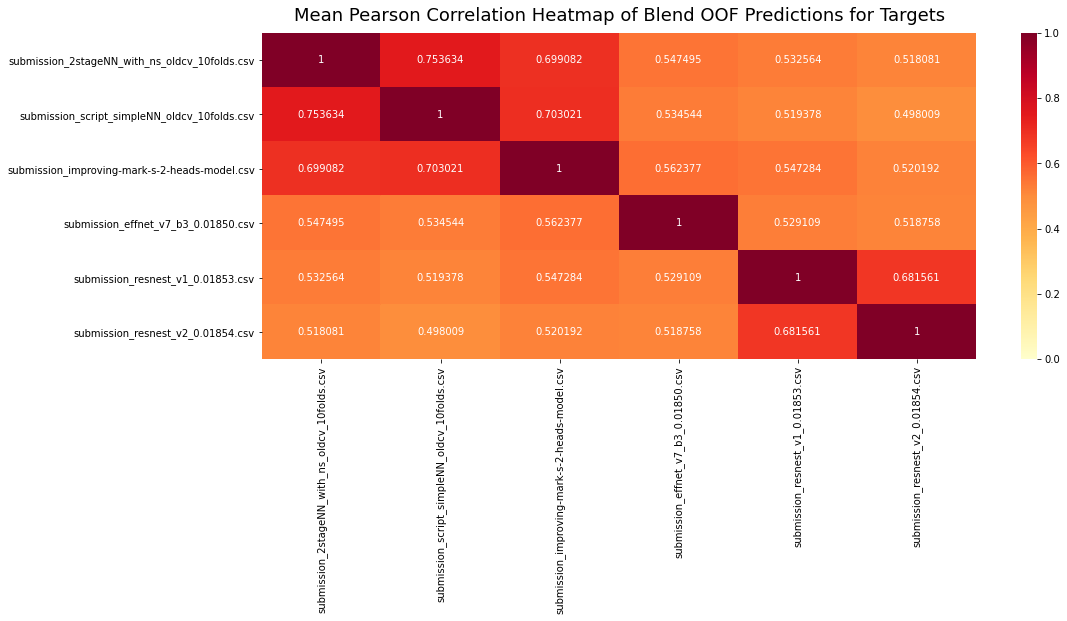

In [85]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(mean_oof_corr,
                      vmin=0,
                      vmax=1,
                      fmt='.6g',
                      cmap='YlOrRd',
                      annot=True)
# center=0.7)
# annot=True)
# cmap='jet')
# cmap='BrBG')
heatmap.set_title(
    'Mean Pearson Correlation Heatmap of Blend OOF Predictions for Targets',
    fontdict={'fontsize': 18},
    pad=12)

Text(0.5, 1.0, 'Mean Spearman Correlation Heatmap of Blend OOF Predictions for Targets')

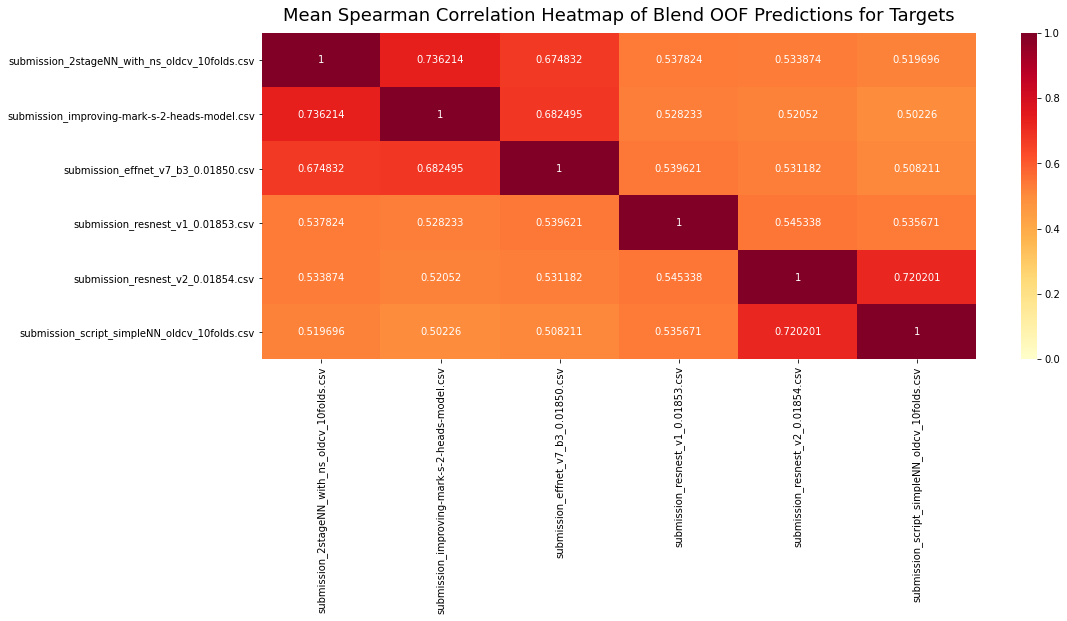

In [94]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(mean_oof_corr,
                      vmin=0,
                      vmax=1,
                      fmt='.6g',
                      cmap='YlOrRd',
                      annot=True)
# center=0.7)
# annot=True)
# cmap='jet')
# cmap='BrBG')
heatmap.set_title(
    'Mean Spearman Correlation Heatmap of Blend OOF Predictions for Targets',
    fontdict={'fontsize': 18},
    pad=12)

In [70]:
if run_submit_script:
    print(submission.shape)
    print(submission)
    submission.to_csv('submission.csv', index=False)

## EOF

In [71]:
if kernel_mode:
    !rm ./*.py
    !ls -la